# Práctico: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [1]:
import pandas  as pd
import seaborn 

from surprise                 import Dataset, Reader, KNNWithMeans
from surprise.accuracy        import rmse
from surprise.model_selection import cross_validate, train_test_split

In [2]:
# Este solo tiene las bandas con los ids
artist_data = pd.read_csv("artists.dat", sep="\t")
print(artist_data.head())
artist_data.describe()

   id               name                                         url  \
0   1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
1   2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
2   3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
3   4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   
4   5        Bella Morte        http://www.last.fm/music/Bella+Morte   

                                          pictureURL  
0    http://userserve-ak.last.fm/serve/252/10808.jpg  
1  http://userserve-ak.last.fm/serve/252/3052066.jpg  
2  http://userserve-ak.last.fm/serve/252/40222717...  
3  http://userserve-ak.last.fm/serve/252/54697835...  
4  http://userserve-ak.last.fm/serve/252/14789013...  


,id
count,17632.000000
mean,9156.636853
std,5392.515296
min,1.000000
25%,4501.750000
50%,9048.500000
75%,13769.250000
max,18745.000000


In [3]:
user_artist_plays = pd.read_csv("user_artists.dat", sep="\t")
print (user_artist_plays.head())
print (user_artist_plays.shape)

   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983
(92834, 3)


## Actividades

El [Ejercicio 1](#Ejercicio-1---Análisis-Exploratorio-de-Datos) deberá ser realizado por quienes estén realizando cualquier parte de la materia.

El [Ejercicio 2](#Ejercicio-2---Sistema-de-Recomendación) variará de acuerdo a que parte de la materia estén realizando, quienes estén realizando la materia completa, deberán realizar ambas partes.

De acuerdo a la parte de la materia que hagan, deberán realizar una de las siguientes actividades (pueden realizar ambas si así lo desean):

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar dos sistemas de recomendación: 
1. El primero, más sencillo, utilizando [Surpr!se](http://surpriselib.com/), y a partir de los datos de LastFM, en especial del archivo `./data/lastfm/user_artists.dat`, generar un sistema de recomendación basado en filtros colaborativos.
2. En el segundo, deberán utilizar todos los datos ofrecidos en el dataset de LastFM para generar un sistema de filtrado colaborativo más complejo, deberá utilizar las técnicas aprendidas 

basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

Cuales son los artistas mas escuchados

In [4]:
# Agrupamos por Id de banda y sumamos la cantidad de veces que fueron escuchados.
sum_listened_artist = user_artist_plays.groupby(["artistID"]).sum()
sum_listened_artist = sum_listened_artist.sort_values(ascending = False, by = 'weight')
sum_listened_artist = sum_listened_artist.drop(columns = ['userID'])
sum_listened_artist

,weight
artistID,
289,2393140
72,1301308
89,1291387
292,1058405
498,963449
...,...
17468,1
14309,1
14308,1


In [5]:
# Seleccionamos los tops artists
select_top_artists = 10
top_artist         = sum_listened_artist.head(select_top_artists)
top_artist

,weight
artistID,
289,2393140
72,1301308
89,1291387
292,1058405
498,963449
67,921198
288,905423
701,688529
227,662116


In [6]:
# Mostramos los nombres los artistas.
top_artists_id = top_artist.index.values
artist_data.loc[artist_data['id'].isin(top_artists_id)]

,id,name,url,pictureURL
61,67,Madonna,http://www.last.fm/music/Madonna,http://userserve-ak.last.fm/serve/252/340387.jpg
66,72,Depeche Mode,http://www.last.fm/music/Depeche+Mode,http://userserve-ak.last.fm/serve/252/75022.jpg
83,89,Lady Gaga,http://www.last.fm/music/Lady+Gaga,http://userserve-ak.last.fm/serve/252/47390093...
221,227,The Beatles,http://www.last.fm/music/The+Beatles,http://userserve-ak.last.fm/serve/252/2588646.jpg
282,288,Rihanna,http://www.last.fm/music/Rihanna,http://userserve-ak.last.fm/serve/252/53023109...
283,289,Britney Spears,http://www.last.fm/music/Britney+Spears,http://userserve-ak.last.fm/serve/252/60126439...
286,292,Christina Aguilera,http://www.last.fm/music/Christina+Aguilera,http://userserve-ak.last.fm/serve/252/47363849...
294,300,Katy Perry,http://www.last.fm/music/Katy+Perry,http://userserve-ak.last.fm/serve/252/42128121...
492,498,Paramore,http://www.last.fm/music/Paramore,http://userserve-ak.last.fm/serve/252/35837991...
695,701,Shakira,http://www.last.fm/music/Shakira,http://userserve-ak.last.fm/serve/252/52116105...


¿Cómo es la distribución de cantidad de listens por user?

      userID  artistID  weight
3764      80       768       7
3765      80       779     245
3766      80       805    1170
3767      80       813     281
3768      80       815       7


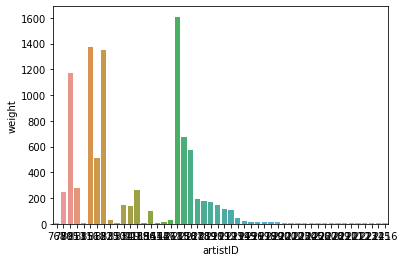

In [7]:
# Hay que examinar por user como es que se distrubuye la cantidad de listen por artista ? [FIXME] preguntar bien que onda esta pregunta.
selected_user = 80
selected_user_data = user_artist_plays[user_artist_plays.userID == selected_user]
print (selected_user_data.head(5))
seaborn.barplot(x = 'artistID', y = 'weight', data = selected_user_data)

# Depende del user.
# Algunos tienen un artista que escuchan solo ese y despues nada mas. 
# Mientras que otros un top que escuchan similar.

¿Es posible ver el género más escuchado?

In [8]:
tags_data = pd.read_csv("tags.dat", sep="\t", encoding = "ISO-8859-1")
print (tags_data.tagValue.unique())
tags_data.head(10)

['metal' 'alternative metal' 'goth rock' ... 'sverige' 'eire'
 'electro latino']


,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
5,6,industrial metal
6,7,gothic metal
7,8,terror ebm
8,9,electro-industrial
9,10,harsh ebm


En este archivo tags, pareciera que estan los generos, pero son demasiados distintos para poder considerarlos como categorias. Segun yo no puede haber tantos generos musicales.

## Ejercicio 2 - Sistema de Recomendación

### Ejercicio 2a - Filtrados Colaborativos

Esta parte del ejercicio es obligatoria para aprobar la parte introductoria de la materia (i.e. los contenidos que se ven en las dos primeras clases), quienes estén realizando la materia completa deerán realizar también el [Ejercicio 2b](#Ejercicio-2b---Sistemas-de-Recomendación-Avanzados). 

Deberán realizar un sistema de filtrados colaborativos basado en [Surpr!se](http://surpriselib.com/), a partir de los datos que proporciona `LastFM`, en especial el archivo `user_artists.dat`. Tener en cuenta los siguientes pasos:

1. **Desarrollo de la matriz de Usuario-Contenido:** A partir del conjunto de datos deberán generar una matriz de usuario-contenido. Tener en cuenta que los ratings son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a determinado artista.
2. **Entrenamiento del algoritmo de recomendación**: Utilizando las herramientas brindadas por [Surpr!se](http://surpriselib.com/), entrenen varios modelos (al menos 3) de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo. Si necesitan inspiración, les recomendamos revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).
3. **Sistema de recomendación**: A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [42]:
# Creamos la matriz de usuario contenido.
matrix = user_artist_plays.pivot_table(index = 'userID', columns = 'artistID', values = 'weight').fillna(0)

In [43]:
matrix

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Debemos normalizar los rating implicitos a explicitos
# Dividiendo los weights por el maximo de cada usuario.

# Get the max amount of listens per user.
max_per_user_array = matrix.max(axis = 1).values

# Divide each value per user to get and explicit rating.
explicit_rating_matrix = matrix.divide(max_per_user_array, axis = 0)
explicit_rating_matrix

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Its better explained here
# https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
# user_artist_plays[['userID', 'artistID', 'weight']]

min_weight = user_artist_plays.weight.min()
max_weight = user_artist_plays.weight.max()

reader     = Reader(rating_scale = (min_weight, max_weight))
ratings    = Dataset.load_from_df(user_artist_plays[['userID', 'artistID', 'weight']], reader)

In [13]:
train_data, test_data = train_test_split(ratings, test_size=0.2)
model                 = KNNWithMeans(k=5).fit(train_data)
predictions           = model.test(test_data)

print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 5256.0113


<!-- ### Ejercicio 2b - Sistemas de Recomendación Avanzados -->

Este ejercicio lo deberán completar quienes hayan realizado ambas partes de la materia pues requiere de los conocimientos adquiridos en las segundas dos clases. En este caso, utilizarán no sólo la información de la matriz de usuario-contenido, sino que deberán hacer uso de otra información para poder lidiar con el problema del "Cold Start", i.e. que es lo que ocurre cuando tengo nuevos usuarios o artistas. Tener en cuenta los siguientes pasos:
1. **Evaluación sobre cold start**: Para evaluar como funciona el sistema con el problema del "cold start", deberán tomar ciertos artistas y "dejarlos fuera", i.e. remover cualquier participación del artista en el sistema. Esos serán los artistas que se evaluarán como "cold start".
2. **Vectores de contenido**: Deberán generar vectores de contenido para los artistas, basados en los tags que los usuarios les dan (ver los archivos `user_taggedartists.dat` y `tags.dat`).
3. **Sistema de recomendación**: Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.
4. **Evaluación del sistema**: Deberán evaluar "a mano" el sistema sobre artistas que conozca y artistas que no conozca (i.e. que fueron dejados afuera), y hacer un análisis de lo que el sistema está devolviendo.

In [14]:
# Completar...